# Mechanisms underlying cleavage site heterogeneity

**Purpose**: To investigate the cis-regulatory elements controlling cleavage site heterogeneity.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
from paper_utilities import cleavage

from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import test_proportions_2indep


In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation/yeast"
CLVDIR  = os.path.join(PROJECT, 'saccharomyces_cerevisiae', 'analysis', 'motif_analysis', 'cleavage_motifs')
OUTDIR  = os.path.join(PROJECT, 'manuscript', 'analysis', 'cleavage_heterogeneity')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
## Load motif family definitions for S. cerevisiae

scer_definitions = {'patterns' : {}, 'distance' : {}}

# By pattern - we only look at pattern families for 6mers
with open(os.path.join(RESOURCES, f'motif_definitions.scer.6mers.patterns.pickle'), mode = 'rb') as handle:
    scer_definitions['patterns'][6] = pickle.load(handle)
    
scer_definitions['patterns'][5] = {'family':{}}
scer_definitions['patterns'][4] = {'family':{}}

# By Hamming distance
for kmer in [4,5,6]:
    with open(os.path.join(RESOURCES, f'motif_definitions.scer.{kmer}mers.distance.pickle'), mode = 'rb') as handle:
        scer_definitions['distance'][kmer] = pickle.load(handle)


In [7]:
with open(os.path.join(RESOURCES, 'gold_data.ctr.pickle'), mode = 'rb') as handle:
    gold_data = pickle.load(handle)
    
with open(os.path.join(RESOURCES, 'gold_data.cleavage_heterogeneity.ctr.pickle'), mode = 'rb') as handle:
    gold_tpdata = pickle.load(handle)

print(gold_data.shape)
print(gold_tpdata.shape)


(11673, 445)
(11400, 457)


In [8]:
evar  = 'observed_entropy_group'
evals = np.arange(1,4,1)
elow  = 1
ehigh = 3

entropy_group_palette = {
    1 : '#3375a2',
    2 : '#e1822c',
    3 : '#3b9344'
}

motif_count_palette = {
    1 : '#5066af',
    2 : '#15b4e9',
    3 : '#79cbbb'
}

In [9]:
boxplot_format = {
    'boxprops'     : {'edgecolor' : 'black', 'linewidth' : 0.5},
    'medianprops'  : {'color' : 'black', 'linewidth' : 0.5},
    'whiskerprops' : {'color' : 'black', 'linewidth' : 0.5},
    'capprops'     : {'color' : 'black', 'linewidth' : 0.5},
    'flierprops'   : {'color' : 'black'},
    'showfliers'   : False
}

barplot_format = {
    'color'     : 'lightgray',
    'edgecolor' : 'black',
    'linewidth' : 0.5,
}

## ANALYSIS

### Examples of high and low entropy sites

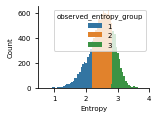

In [10]:
fig,ax = plt.subplots(1,1, figsize = (2,1.5))

sns.histplot(data = gold_tpdata, x = 'observed_entropy', 
             hue = evar, palette = entropy_group_palette, multiple = 'stack',
             alpha = 1, binwidth = 0.05, linewidth = 0, ax = ax)

ax.set_xlabel("Entropy")
ax.set_xlim(None,4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_obs_only.distribution.observed_entropy.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Low entropy examples


Example 0: gene=YDR525W-A, location=(IV, 1490913, +)
	Observed entropy: 1.177
	Cleavage site sequence: CTACCCTTTTTTTTTCATTTCTTTCTTTTT


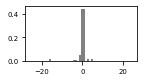


Example 1: gene=YML115C, location=(XIII, 40130, -)
	Observed entropy: 1.489
	Cleavage site sequence: TTTTTTGTTTTGTTTTATTTCGTTTTGTTT


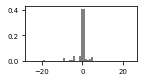


Example 2: gene=YER136W, location=(V, 441216, +)
	Observed entropy: 1.589
	Cleavage site sequence: CTTTCCTTTTCTTTTCTTTCAATTTCTTTT


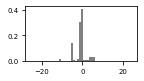


Example 3: gene=YKL023W, location=(XI, 394647, +)
	Observed entropy: 1.920
	Cleavage site sequence: AACTTCTTTTCTTTTTATTCTTATTTTCTT


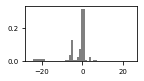


Example 4: gene=YGL157W, location=(VII, 210140, +)
	Observed entropy: 1.929
	Cleavage site sequence: TTTTTTTTACATTGCCAGTTTTCTTTTTTC


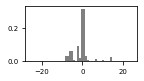

In [11]:
example_sites = [
    ('YDR525W-A',   'IV', 1490913, '+'),
    ('YML115C',   'XIII',   40130, '-'),
    ('YER136W',      'V',  441216, '+'),
    ('YKL023W',     'XI',  394647, '+'),
    ('YGL157W',    'VII',  210140, '+')
]

for i, example_entry in enumerate(example_sites):
    
    ex_gene, ex_chrom, ex_start, ex_strand = example_entry
    ex_data = gold_tpdata.loc[(gold_tpdata['gene'] == ex_gene) & (gold_tpdata['start'] == ex_start)].iloc[0]

    print(f"\nExample {i}: gene={ex_data['gene']}, location=({ex_data['chrom']}, {ex_data['start']}, {ex_data['strand']})")
    print(f"\tObserved entropy: {ex_data['observed_entropy']:.03f}")
    print(f"\tCleavage site sequence: {ex_data['sequence'][int(ex_data['ctr_cleavage']-15):int(ex_data['ctr_cleavage']+15)]}")

    fig,ax = plt.subplots(1,1, figsize = (2,1))
    xs = np.arange(-25,25,1)
    ax.bar(xs, ex_data['observed_norm'], color = 'gray', width = 1)
    plt.show()


#### High entropy examples

3.1240996734287414


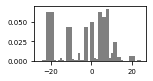

In [12]:
ex2_gene, ex2_chrom, ex2_start = ('YOR117W', 'XV', 546422)

ex2_data = gold_tpdata.loc[(gold_tpdata['gene'] == ex2_gene) & (gold_tpdata['chrom'] == ex2_chrom) & (gold_tpdata['start'] == ex2_start)].iloc[0]
print(ex2_data['observed_entropy'])

fig,ax = plt.subplots(1,1, figsize = (2,1))
xs = np.arange(-25,25,1)
ax.bar(xs, ex2_data['observed_norm'], color = 'gray', width = 1)
plt.show()


3.2491343098705077


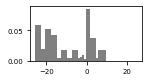

In [13]:
ex3_gene, ex3_chrom, ex3_start = ('YNL290W', 'XIV', 87314)
ex3_data = gold_tpdata.loc[(gold_tpdata['gene'] == ex3_gene) & (gold_tpdata['chrom'] == ex3_chrom) & (gold_tpdata['start'] == ex3_start)].iloc[0]
print(ex3_data['observed_entropy'])

fig,ax = plt.subplots(1,1, figsize = (2,1))
xs = np.arange(-25,25,1)
ax.bar(xs, ex3_data['observed_norm'], color = 'gray', width = 1)
plt.show()


### High entropy sites show no difference in PolyaClassifier probability but are weaker according to PolyaStrength

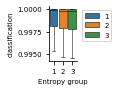


Corresponding statistics-
	Kruskal-Wallis test (all groups):	 17.636 1.48E-04
	Wilcoxon rank sum test (group 3 vs 1):	  3.949 7.84E-05


In [14]:
fig,ax = plt.subplots(1,1, figsize = (0.5,1))

y = 'classification'

sns.boxplot(data = gold_tpdata, x = evar, y = y, hue = evar, 
            palette = entropy_group_palette, dodge = False, saturation = 1,
            **boxplot_format, ax = ax)

ax.set_xlabel("Entropy group")

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_obs_only.boxplot.{y}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("\nCorresponding statistics-")

stat, pval = st.kruskal(*[gold_tpdata.loc[gold_tpdata[evar] == e, y] for e in evals])
print(f"\tKruskal-Wallis test (all groups):\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(gold_tpdata.loc[gold_tpdata[evar] == elow,  y],
                         gold_tpdata.loc[gold_tpdata[evar] == ehigh, y])
print(f"\tWilcoxon rank sum test (group {ehigh} vs {elow}):\t{stat:7.03f} {pval:8.02E}")


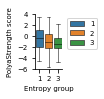


Corresponding statistics-
	Kruskal-Wallis test (all groups):	309.830 5.26E-68
	Wilcoxon rank sum test (group 3 vs 1):	 17.126 9.46E-66


In [15]:
fig,ax = plt.subplots(1,1, figsize = (0.5,1))

y = 'pred_logit'

sns.boxplot(data = gold_tpdata, x = evar, y = y, hue = evar, 
            palette = entropy_group_palette, dodge = False, saturation = 1,
            **boxplot_format, ax = ax)

ax.set_xlabel("Entropy group")
ax.set_ylabel("PolyaStrength score")

ax.set_ylim(-6,4)
ax.yaxis.set_major_locator(MultipleLocator(2))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_obs_only.boxplot.{y}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("\nCorresponding statistics-")

stat, pval = st.kruskal(*[gold_tpdata.loc[gold_tpdata[evar] == e, y] for e in evals])
print(f"\tKruskal-Wallis test (all groups):\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(gold_tpdata.loc[gold_tpdata[evar] == elow,  y],
                         gold_tpdata.loc[gold_tpdata[evar] == ehigh, y])
print(f"\tWilcoxon rank sum test (group {ehigh} vs {elow}):\t{stat:7.03f} {pval:8.02E}")


### Enriched motifs by entropy group 

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-250, -120)
     testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
810     GTCAGA         1.255109         6.053900  0.002335
2703    AGAACC         0.924389         5.354771  0.004995
     testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
3891    CCTAGT        -2.737130         5.943053  0.002335
3449    GCACTG        -1.865249         5.097538  0.004995

Enriched in high entropy: {'GTCAGA': 0.5306402751183189, 'AGAACC': 0.4693597248816811}
Enriched in low entropy: {'GCACTG': 0.4617087715091092, 'CCTAGT': 0.5382912284908908}


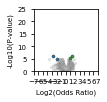

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-120, -90)
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

Enriched in high entropy: {}
Enriched in low entropy: {}


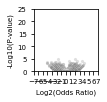

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-90, -50)
     testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
1826    TAAATA         0.938516        15.072993  1.717633e-12
978     AAATAA         0.792636         8.627426  3.194524e-06
1384    TATTTA         0.731287         7.483141  3.340051e-05
1927    ATAAAT         0.758899         7.326861  3.829326e-05
1015    TTATAA         0.983534         6.379252  2.828464e-04
573     TTTATA         0.590999         5.661062  1.267051e-03
576     TATACA         0.721253         5.352780  2.159015e-03
462     ATGTAT         0.637198         5.307726  2.159015e-03
1540    TACATA         0.606037         5.270918  2.159015e-03
1811    TTAAAT         0.834049         5.233305  2.159015e-03
575     ATATAC         0.667798         5.166181  2.309891e-03
    testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
153    TTTTTT        -0.929106        20.626526  9.603464e-18

Enriched in high entropy: {'ATGTAT': 0.06903762630863253, 'TTTATA': 0.07363346150713276, 'ATATAC': 

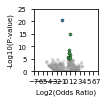

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-50, -30)
     testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
979     AATAAT         1.357534         9.775585  2.126974e-07
2052    TAATAA         1.156661         7.895673  9.678884e-06
872     TAATCA         1.921741         5.466454  1.583299e-03
     testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
465     TATATA        -0.863522        23.283522  1.981286e-20
1280    ATATAT        -0.691273        12.928937  2.241310e-10
1540    TACATA        -0.864752         9.182273  6.253681e-07
200     TATGTA        -0.751573         7.779638  1.053610e-05
574     TTATAT        -0.721632         5.633156  1.265363e-03
575     ATATAC        -0.741814         5.426663  1.583299e-03
323     TTAGAT        -2.358547         5.317212  1.833397e-03

Enriched in high entropy: {'TAATCA': 0.2362573262368769, 'AATAAT': 0.4224957461180311, 'TAATAA': 0.3412469276450921}
Enriched in low entropy: {'TATGTA': 0.11185450866740745, 'TTAGAT': 0.07645010963603835, 'TATATA': 0.334767

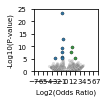

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-30, -15)
  testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
6    GATAAT         2.323194         5.118747  0.006626
    testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
62     AAAAAA        -1.491146        15.686913  7.674129e-13
457    ATAAAA        -1.067832         9.129854  1.383749e-06
465    TATATA        -0.982807         7.848724  1.762366e-05
791    TAAAAA        -0.861915         5.051734  6.625790e-03

Enriched in high entropy: {'GATAAT': 1.0}
Enriched in low entropy: {'AAAAAA': 0.41590844805948424, 'ATAAAA': 0.24206060306773397, 'TATATA': 0.2080938960646349, 'TAAAAA': 0.13393705280814683}


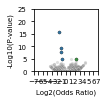

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-15, 15)
     testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
716     ATAATA         2.311096        24.223777  2.410276e-22
2052    TAATAA         2.367797        20.896254  3.415849e-19
63      AAAAAT         2.090120        18.286141  9.942211e-17
979     AATAAT         1.876922        15.683776  3.342929e-14
64      AAAATA         1.968795        13.089866  1.025246e-11
...        ...              ...              ...           ...
1341    TTTAAG         1.633126         5.227226  1.382202e-04
541     TACTAA         2.000735         5.207584  1.437839e-04
1211    ACAAAT         1.688873         5.116456  1.743470e-04
1928    TAAATG         1.915005         5.058030  1.974640e-04
1850    TCATAA         1.609647         5.057503  1.974640e-04

[95 rows x 4 columns]
     testMotif  odds_ratio_log2  pvalue_minlog10         qvalue
153     TTTTTT        -2.047150       174.419340  1.536397e-171
175     TTCTTT        -2.280403        59.199275   1.275084e-56
176     TC

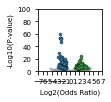

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (-15, 15)
     testMotif  odds_ratio_log2  pvalue_minlog10        qvalue
716     ATAATA         2.311096        24.223777  2.410276e-22
2052    TAATAA         2.367797        20.896254  3.415849e-19
63      AAAAAT         2.090120        18.286141  9.942211e-17
979     AATAAT         1.876922        15.683776  3.342929e-14
64      AAAATA         1.968795        13.089866  1.025246e-11
...        ...              ...              ...           ...
1341    TTTAAG         1.633126         5.227226  1.382202e-04
541     TACTAA         2.000735         5.207584  1.437839e-04
1211    ACAAAT         1.688873         5.116456  1.743470e-04
1928    TAAATG         1.915005         5.058030  1.974640e-04
1850    TCATAA         1.609647         5.057503  1.974640e-04

[95 rows x 4 columns]
     testMotif  odds_ratio_log2  pvalue_minlog10         qvalue
153     TTTTTT        -2.047150       174.419340  1.536397e-171
175     TTCTTT        -2.280403        59.199275   1.275084e-56
176     TC

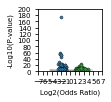

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (15, 30)
     testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
2382    AAACCA         5.001227         6.755570  0.000699
255     AAGAAA         1.429362         5.465776  0.006814
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

Enriched in high entropy: {'AAGAAA': 0.4472319484284275, 'AAACCA': 0.5527680515715726}
Enriched in low entropy: {}


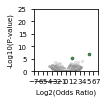

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (30, 50)
   testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
62    AAAAAA         0.693219         8.039007  0.000037
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

Enriched in high entropy: {'AAAAAA': 1.0}
Enriched in low entropy: {}


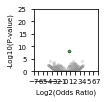

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (50, 90)
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []
    testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
708    TAGCCT        -3.322345         5.221909  0.024525

Enriched in high entropy: {}
Enriched in low entropy: {'TAGCCT': 1.0}


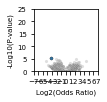

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (90, 120)
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []
Empty DataFrame
Columns: [testMotif, odds_ratio_log2, pvalue_minlog10, qvalue]
Index: []

Enriched in high entropy: {}
Enriched in low entropy: {}


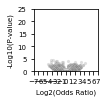

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



Region: (120, 250)
     testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
466     ATATAA         0.740463         8.294110  0.000021
1480    AATTGT         0.798092         5.286947  0.004526
     testMotif  odds_ratio_log2  pvalue_minlog10    qvalue
1269    CTTTGT        -0.907281         5.754372  0.002988
1342    TTGTGT        -1.132764         5.659892  0.002988
1548    TACGTA        -1.238428         5.257640  0.004526

Enriched in high entropy: {'ATATAA': 0.6107116450863973, 'AATTGT': 0.3892883549136028}
Enriched in low entropy: {'CTTTGT': 0.3451538591794925, 'TTGTGT': 0.3394868126844303, 'TACGTA': 0.3153593281360772}


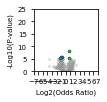

In [16]:
region_results = []
regions = [(-250,-120), (-120,-90), (-90,-50), (-50,-30), (-30,-15), (-15,15), (-15,15), (15,30), (30,50), (50,90), (90,120), (120,250)]
labels = ['full','full','full','full','full','full','zoom','full','full','full','full','full']
ylims = [25,25,25,25,25,100,200,25,25,25,25,25]
yints = [5,5,5,5,5,20,20,5,5,5,5,5]
group = 'entropy'
kmer = 6

for region,label,ylim_up,yint_up in zip(regions,labels,ylims,yints):

    dt = pd.read_csv(os.path.join(CLVDIR, f'cleavage_motifs.{kmer}mers.enrichment_{region[0]}_{region[1]}.txt'), sep = "\t")
    dt = dt.replace([np.inf, -np.inf], np.nan).dropna()
    
    dt['odds_ratio_log2'] = np.log2(dt['odds_ratio'])
    dt['pvalue_minlog10'] = -1 * np.log10(dt['pvalue'])
    
    dt['qvalue'] = multipletests(dt['pvalue'], alpha = 0.05, method = 'fdr_bh')[1]
    dt['qvalue_minlog10']  = -1 * np.log10(dt['qvalue'])
    
    region_results.append(dt)
    
    
    ## make plot
    
    fig,ax = plt.subplots(1,1, figsize = (1.15,1.15))
    
    sns.scatterplot(data = dt,  x = 'odds_ratio_log2', y = 'pvalue_minlog10', 
                    s = 10, color = 'gray', alpha = 0.25, rasterized = True,
                    ax = ax)
    
    ax.set_xlim((-7,7))
    ax.xaxis.set_major_locator(MultipleLocator(1))

    ax.set_ylim((0,ylim_up))
    ax.yaxis.set_major_locator(MultipleLocator(yint_up))
    
    ax.set_xlabel("Log2(Odds Ratio)")
    ax.set_ylabel("-Log10(P-value)")

    ## annotate plots
    
    print("\nRegion:", region)
    
    condSIG = (dt['qvalue'] < 0.05) & (dt['pvalue_minlog10'] > 5)
    
    pos_sig = dt.loc[condSIG & (dt['odds_ratio_log2'] > 0)]
    neg_sig = dt.loc[condSIG & (dt['odds_ratio_log2'] < 0)]
    
    print(pos_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    print(neg_sig[['testMotif','odds_ratio_log2', 'pvalue_minlog10', 'qvalue']].sort_values('pvalue_minlog10', ascending = False))
    
    print("\nEnriched in high entropy:", dict(zip(pos_sig['testMotif'], pos_sig['pvalue_minlog10'] / pos_sig['pvalue_minlog10'].sum())))
    print("Enriched in low entropy:", dict(zip(neg_sig['testMotif'], neg_sig['pvalue_minlog10'] / neg_sig['pvalue_minlog10'].sum())))
    
    for i,dtrow in dt.loc[condSIG].iterrows():
        
        if (dtrow['odds_ratio_log2'] > 0):
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = entropy_group_palette[3], edgecolor = 'black', linewidths = 0.25)
        else:
            ax.scatter(x = dtrow['odds_ratio_log2'], y = dtrow['pvalue_minlog10'], s = 10, color = entropy_group_palette[1], edgecolor = 'black', linewidths = 0.25)

    plt.savefig(os.path.join(OUTDIR, f'motif_enrichment.region_scatter_{region}.{label}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()


## 

### Tabulating cis-regulatory element occurrences by region

#### Presence of multiple motifs in targeted regions


UA_d2_-90_-50


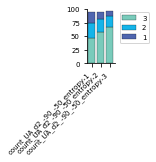


Chi2 test for independence across entropy groups:
	count_UA_d2_-90_-50	3.14E-35

Summary data:
value                                 0          1          2          3
label                                                                   
count_UA_d2_-90_-50_entropy-1  6.403509  18.991228  27.236842  47.368421
count_UA_d2_-90_-50_entropy-2  4.839181  14.385965  24.064327  56.710526
count_UA_d2_-90_-50_entropy-3  3.377193   9.868421  20.877193  65.877193

UA_d2_-50_-30


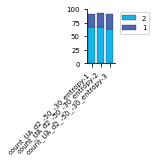


Chi2 test for independence across entropy groups:
	count_UA_d2_-50_-30	4.18E-03

Summary data:
value                                 0          1          2
label                                                        
count_UA_d2_-50_-30_entropy-1  8.596491  23.859649  67.543860
count_UA_d2_-50_-30_entropy-2  7.923977  25.307018  66.769006
count_UA_d2_-50_-30_entropy-3  9.956140  26.578947  63.464912

A_d2_-45_-15


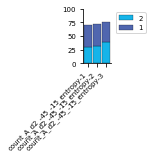


Chi2 test for independence across entropy groups:
	count_A_d2_-45_-15	2.76E-11

Summary data:
value                                 0          1          2
label                                                        
count_A_d2_-45_-15_entropy-1  29.649123  40.087719  30.263158
count_A_d2_-45_-15_entropy-2  27.660819  40.307018  32.032164
count_A_d2_-45_-15_entropy-3  25.219298  35.307018  39.473684

U_d2_-15_0


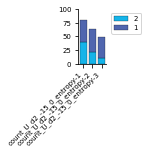


Chi2 test for independence across entropy groups:
	count_U_d2_-15_0	1.87E-165

Summary data:
value                               0          1          2
label                                                      
count_U_d2_-15_0_entropy-1  19.780702  39.692982  40.526316
count_U_d2_-15_0_entropy-2  36.520468  41.812865  21.666667
count_U_d2_-15_0_entropy-3  51.052632  38.245614  10.701754

U_d2_0_15


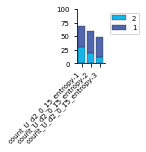


Chi2 test for independence across entropy groups:
	count_U_d2_0_15	3.20E-71

Summary data:
value                              0          1          2
label                                                     
count_U_d2_0_15_entropy-1  31.315789  38.333333  30.350877
count_U_d2_0_15_entropy-2  40.102339  39.985380  19.912281
count_U_d2_0_15_entropy-3  51.885965  37.061404  11.052632


In [17]:
motif_vars = ['UA_d2_-90_-50','UA_d2_-50_-30','A_d2_-45_-15','U_d2_-15_0','U_d2_0_15']
max_vals   = [3,2,2,2,2]

for v,max_val in zip(motif_vars, max_vals):
    print(f"\n{v}")

    vardata = gold_tpdata[[evar,f'count_{v}']].melt(id_vars = evar)

    vardata['value'] = vardata['value']
    vardata.loc[vardata['value'] > max_val, 'value'] = max_val

    vardata = vardata.groupby([evar,'variable','value']).size().reset_index().rename(columns = {0 : 'count'})

    vardata['varindex'] = vardata['variable'].apply(lambda x : motif_vars.index(x.replace("count_","")))
    vardata['label'] = vardata.apply(lambda row : str(row.variable) + "_entropy-" + str(row[evar]), axis = 1)
    vardata['prop'] = vardata['count'] / vardata.groupby(['variable',evar])['count'].transform('sum') * 100

    varcounts = (vardata
                 .pivot(index = 'label', columns = 'value', values = 'prop').fillna(0)
                 .loc[vardata.sort_values(['varindex',evar])['label'].unique()]
    )



    fig,ax = plt.subplots(1,1, figsize = (0.5,1))

    labels = varcounts.index.values
    bottoms = np.zeros((len(varcounts)))

    for c in varcounts.columns[::-1]:
        if (c > 0):
            heights = varcounts[[c]].to_numpy().flatten()
            ax.bar(labels, heights, bottom = bottoms, label = c, color = motif_count_palette[c], edgecolor = 'black', linewidth = 0.25)
            bottoms = bottoms + heights

    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation = 45, ha = 'right', va = 'top')

    ax.set_ylim(0,100)
    ax.yaxis.set_major_locator(MultipleLocator(25))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.legend(bbox_to_anchor = (1.05,1))

    plt.savefig(os.path.join(OUTDIR, f'known_cis_elements.by_entropy.counts.d2.{v}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()


    print("\nChi2 test for independence across entropy groups:")

    for var in vardata.sort_values('varindex')['variable'].unique():
        varwide = vardata.loc[vardata['variable'] == var].pivot(index = 'value', columns = evar, values = 'count').fillna(0).to_numpy()
        print(f"\t{var}\t{st.chi2_contingency(varwide)[1]:.02E}")

    print("\nSummary data:")
    print(varcounts)


#### Presence of A-rich motifs across regions

In [18]:
## Define important sub-regions for each family of motifs

gold_motifs = {
    'EE' : {
        'var_root' : 'UA_d2_',
        'regions'  : [(-105,-90),(-90,-50),(-50,-30),(-30,-15),(-15,0),(0,15),(15,30)],
    },
    'PE' : {
        'var_root' : 'A_d2_',
        'regions'  : [(-60,-45),(-45,-30),(-30,-15),(-15,0),(0,15),(15,30),(30,45)],
    },
    'UF' : {
        'var_root' : 'U_d2_',
        'regions'  : [(-60,-45),(-45,-30),(-30,-15),(-15,0),(0,15),(15,30),(30,45)],
    },
}




### PE


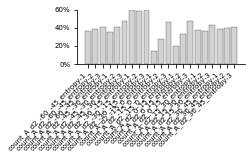


Hypothesis test for two proportions
	count_A_d2_-60_-45	1.05E-02
	count_A_d2_-45_-30	1.19E-18
	count_A_d2_-30_-15	9.28E-01
	count_A_d2_-15_0  	2.49E-137
	count_A_d2_0_15   	3.72E-94
	count_A_d2_15_30  	9.36E-05
	count_A_d2_30_45  	9.01E-02


In [19]:
for element,edict in gold_motifs.items():
    
    if (element != 'PE'):
        continue
    
    print("\n\n###", element)
    
    varnames = [edict['var_root'] + str(region[0]) + "_" + str(region[1]) for region in edict['regions']]

    vardata = gold_tpdata[[evar] + [f'count_{v}' for v in varnames]].melt(id_vars = evar)
    vardata['value'] = (vardata['value'] > 0).astype(int)

    vardata = vardata.groupby([evar,'variable','value']).size().reset_index().rename(columns = {0 : 'count'})
    
    vardata['varindex'] = vardata['variable'].apply(lambda x : varnames.index(x.replace("count_","")))
    vardata['label'] = vardata.apply(lambda row : str(row.variable) + "_entropy-" + str(row[evar]), axis = 1)
    vardata['prop'] = vardata['count'] / vardata.groupby(['variable',evar])['count'].transform('sum') * 100

    varcounts = (vardata
                 .pivot(index = 'label', columns = 'value', values = 'prop').fillna(0)
                 .loc[vardata.sort_values(['varindex',evar])['label'].unique()]
    )
    
    varsum = (vardata
              .pivot(index = 'label', columns = 'value', values = 'count').fillna(0)
              .loc[vardata.sort_values(['varindex',evar])['label'].unique()]
    )


    fig,ax = plt.subplots(1,1, figsize = (3,1))

    labels = varcounts.index.values
    heights = varcounts[[1]].to_numpy().flatten()
    
    ax.bar(labels, heights, color = 'lightgray', edgecolor = 'black', linewidth = 0.25)

    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation = 45, ha = 'right', va = 'top')
    
    ax.set_ylim(0,60)
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_major_formatter(PercentFormatter())
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig(os.path.join(OUTDIR, f'known_cis_elements.by_entropy.presence.{element}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()
    
    
    print("\nHypothesis test for two proportions")
    for var in vardata.sort_values('varindex')['variable'].unique():
    
        prop_test = test_proportions_2indep(count1 = varsum.loc[f'{var}_entropy-1', 1], 
                                            count2 = varsum.loc[f'{var}_entropy-3', 1], 
                                            nobs1  = varsum.loc[f'{var}_entropy-1', 0] + varsum.loc[f'{var}_entropy-1', 1],
                                            nobs2  = varsum.loc[f'{var}_entropy-3', 0] + varsum.loc[f'{var}_entropy-3', 1])
        
        print(f"\t{var:18}\t{prop_test.pvalue:.02E}")


### Mechanism 1: Decreased U-richness surrounding the cleavage site with flanking elements farther apart

#### Nucleotide density plots for the region immediately surrounding the maximum cleavage site

In [20]:
nt_dict = {}
char_dict = {'A':0, 'C':1, 'G':2, 'T':3, 0:'A', 1:'C', 2:'G', 3:'T'}

for e in evals:
    
    top_sites = gold_tpdata.loc[gold_tpdata[evar] == e]
    nt_array = np.zeros((180,4))
    
    for i,row in top_sites.iterrows():
        xs = np.arange(0,180)
        
        for j,char in zip(xs,row['sequence'][int((len(row['sequence'])/2)-90):int((len(row['sequence'])/2)+90)].upper()):

            if (char == 'N'):
                continue

            nt_array[j,char_dict[char]] += 1

    nt_norm = nt_array / np.reshape(np.sum(nt_array, axis = 1), (-1,1))
    nt_dict[e] = nt_norm


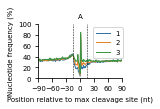

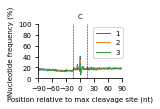

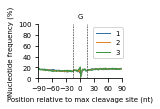

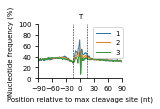

In [21]:
for i,l in zip(range(4), ['A','C','G','T']):
    
    fig,ax = plt.subplots(1,1, figsize = (1.5,1))
    xs = np.arange(-90,90,1)

    for e in evals:
        plot_data = nt_dict[e]
        ax.plot(xs, plot_data[:,i]*100, linewidth = 1, color = entropy_group_palette[e], label = e)

    ax.axvline(x = -15, color = 'black', linewidth = 0.5, linestyle = 'dashed')
    ax.axvline(x = +15, color = 'black', linewidth = 0.5, linestyle = 'dashed')
    ax.legend(bbox_to_anchor = (1.05,1))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel("Position relative to max cleavage site (nt)")
    ax.set_xlim(-90,90)
    ax.xaxis.set_major_locator(MultipleLocator(30))
    
    ax.set_ylim(0,100)
    ax.yaxis.set_major_locator(MultipleLocator(20))

    ax.set_ylabel("Nucleotide frequency (%)")
    ax.set_title(l, fontsize = 7)

    plt.savefig(os.path.join(OUTDIR, f'nucleotide_density.by_entropy_obs_only.{l}.wide.svg'), format = 'svg', dpi = 600)
    plt.show()


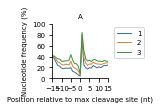

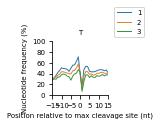

In [22]:
for i,l in zip(range(4), ['A','C','G','T']):
    
    if (l in ['C','G']):
        continue
    
    fig,ax = plt.subplots(1,1, figsize = (1,1))
    xs = np.arange(-90,90,1)

    for e in evals:
        plot_data = nt_dict[e]
        ax.plot(xs, plot_data[:,i]*100, linewidth = 1, color = entropy_group_palette[e], label = e)

    ax.legend(bbox_to_anchor = (1.05,1))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel("Position relative to max cleavage site (nt)")
    ax.set_xlim(-15,15)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    
    ax.set_ylim(0,100)
    ax.yaxis.set_major_locator(MultipleLocator(20))

    ax.set_ylabel("Nucleotide frequency (%)")
    ax.set_title(l, fontsize = 7)

    plt.savefig(os.path.join(OUTDIR, f'nucleotide_density.by_entropy_obs_only.{l}.zoom.svg'), format = 'svg', dpi = 600)
    plt.show()


#### Quantification of the differences in nucleotide density surrounding the clevage site

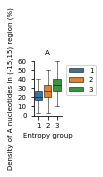


Corresponding statistics-
	Kruskal-Wallis test (all groups):	1644.675 0.00E+00
	Wilcoxon rank sum test (group 3 vs 1):	-37.713 0.00E+00


In [23]:
fig,ax = plt.subplots(1,1, figsize = (0.5,1))

y = 'nd_A'

sns.boxplot(data = gold_tpdata, x = evar, y = y, hue = evar, 
            palette = entropy_group_palette, dodge = False, saturation = 1,
            **boxplot_format, ax = ax)

ax.set_xlabel("Entropy group")
ax.set_ylabel("Density of A nucleotides in (-15,15) region (%)")
ax.set_title("A", fontsize = 7)

ax.set_ylim(0,60)
ax.yaxis.set_major_locator(MultipleLocator(10))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_obs_only.boxplot.{y}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("\nCorresponding statistics-")

stat, pval = st.kruskal(*[gold_tpdata.loc[gold_tpdata[evar] == e, y] for e in evals])
print(f"\tKruskal-Wallis test (all groups):\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(gold_tpdata.loc[gold_tpdata[evar] == elow,  y],
                         gold_tpdata.loc[gold_tpdata[evar] == ehigh, y])
print(f"\tWilcoxon rank sum test (group {ehigh} vs {elow}):\t{stat:7.03f} {pval:8.02E}")


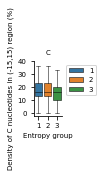


Corresponding statistics-
	Kruskal-Wallis test (all groups):	102.548 5.39E-23
	Wilcoxon rank sum test (group 3 vs 1):	  9.912 3.71E-23


In [24]:
fig,ax = plt.subplots(1,1, figsize = (0.5,1))

y = 'nd_C'

sns.boxplot(data = gold_tpdata, x = evar, y = y, hue = evar, 
            palette = entropy_group_palette, dodge = False, saturation = 1,
            **boxplot_format, ax = ax)

ax.set_xlabel("Entropy group")
ax.set_ylabel("Density of C nucleotides in (-15,15) region (%)")
ax.set_title("C", fontsize = 7)

ax.set_ylim(None,40)
ax.yaxis.set_major_locator(MultipleLocator(10))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_obs_only.boxplot.{y}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("\nCorresponding statistics-")

stat, pval = st.kruskal(*[gold_tpdata.loc[gold_tpdata[evar] == e, y] for e in evals])
print(f"\tKruskal-Wallis test (all groups):\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(gold_tpdata.loc[gold_tpdata[evar] == elow,  y],
                         gold_tpdata.loc[gold_tpdata[evar] == ehigh, y])
print(f"\tWilcoxon rank sum test (group {ehigh} vs {elow}):\t{stat:7.03f} {pval:8.02E}")


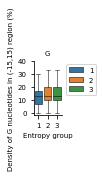


Corresponding statistics-
	Kruskal-Wallis test (all groups):	 30.914 1.94E-07
	Wilcoxon rank sum test (group 3 vs 1):	 -5.309 1.10E-07


In [25]:
fig,ax = plt.subplots(1,1, figsize = (0.5,1))

y = 'nd_G'

sns.boxplot(data = gold_tpdata, x = evar, y = y, hue = evar, 
            palette = entropy_group_palette, dodge = False, saturation = 1,
            **boxplot_format, ax = ax)

ax.set_xlabel("Entropy group")
ax.set_ylabel("Density of G nucleotides in (-15,15) region (%)")
ax.set_title("G", fontsize = 7)

ax.set_ylim(None,40)
ax.yaxis.set_major_locator(MultipleLocator(10))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_obs_only.boxplot.{y}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("\nCorresponding statistics-")

stat, pval = st.kruskal(*[gold_tpdata.loc[gold_tpdata[evar] == e, y] for e in evals])
print(f"\tKruskal-Wallis test (all groups):\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(gold_tpdata.loc[gold_tpdata[evar] == elow,  y],
                         gold_tpdata.loc[gold_tpdata[evar] == ehigh, y])
print(f"\tWilcoxon rank sum test (group {ehigh} vs {elow}):\t{stat:7.03f} {pval:8.02E}")


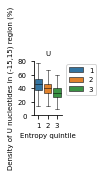


Corresponding statistics-
	Kruskal-Wallis test (all groups):	1029.247 3.18E-224
	Wilcoxon rank sum test (group 3 vs 1):	 30.909 9.13E-210


In [26]:
fig,ax = plt.subplots(1,1, figsize = (0.5,1))

y = 'nd_T'

sns.boxplot(data = gold_tpdata, x = evar, y = y, hue = evar, 
            palette = entropy_group_palette, dodge = False, saturation = 1,
            **boxplot_format, ax = ax)

ax.set_xlabel("Entropy quintile")
ax.set_ylabel("Density of U nucleotides in (-15,15) region (%)")
ax.set_title("U", fontsize = 7)

ax.set_ylim(0,80)
ax.yaxis.set_major_locator(MultipleLocator(20))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_obs_only.boxplot.{y}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("\nCorresponding statistics-")

stat, pval = st.kruskal(*[gold_tpdata.loc[gold_tpdata[evar] == e, y] for e in evals])
print(f"\tKruskal-Wallis test (all groups):\t{stat:7.03f} {pval:8.02E}")

stat, pval = st.ranksums(gold_tpdata.loc[gold_tpdata[evar] == elow,  y],
                         gold_tpdata.loc[gold_tpdata[evar] == ehigh, y])
print(f"\tWilcoxon rank sum test (group {ehigh} vs {elow}):\t{stat:7.03f} {pval:8.02E}")


#### Distance between upstream and downstream flanking U-rich elements in sites that contain both

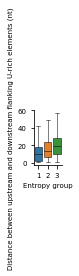


Wilcoxon rank sum test comparing entropy groups 1 and 5-
dist_UF_DF 	 increased 	 7.84770735036044e-108 	 SIG

Summary data-
                         count       mean        std  min   25%   50%   75%  \
observed_entropy_group                                                        
1                       1650.0  11.929091  10.304777  1.0   2.0  10.0  18.0   
2                       4079.0  16.158617  11.792846  1.0   7.0  14.0  24.0   
3                       1084.0  19.964945  12.672036  1.0  10.0  19.0  29.0   

                         max  
observed_entropy_group        
1                       53.0  
2                       59.0  
3                       59.0  


In [27]:
gold_tpdata['dist_UF_DF'] = gold_tpdata['idx_U_d2_0_30'] - gold_tpdata['idx_U_d2_-30_0']

cleavage.distance_boxplot(OUTDIR, 'all', 
                          gold_tpdata, 
                          evar, 'Entropy group', [elow,ehigh], 
                          'dist_UF_DF', 'Distance between upstream and downstream flanking U-rich elements (nt)', 
                          (-2,60), 20, (0.5,1))


### Mechanism 2: A multiplicity of UA/UA-rich motifs located farther upstream from the cleavage site

#### Count of UA/UA-rich motifs in the far upstream regions

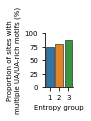

Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples-
8.23260227889886e-26

Summary data-
  observed_entropy_group  multiple_UA_d2_-90_-50  count       prop
0                      1                  1701.0   2280  74.605263
1                      2                  5525.0   6840  80.774854
2                      3                  1978.0   2280  86.754386


In [28]:
fig,ax = plt.subplots(1,1, figsize = (0.5,1))

yvar = 'multiple_UA_d2_-90_-50'

plot_data          = gold_tpdata[[evar, yvar]].groupby(evar).agg('sum')
plot_data['count'] = gold_tpdata.groupby(evar).size()
plot_data['prop']  = plot_data[yvar] / plot_data['count'] * 100
plot_data.reset_index(inplace = True)

sns.barplot(data = plot_data, x = evar, y = 'prop', hue = evar, 
            palette = entropy_group_palette, dodge = False, saturation = 1,
            **barplot_format, ax = ax)

ax.set_xlabel("Entropy group")
ax.set_ylabel("Proportion of sites with\nmultiple UA/UA-rich motifs (%)")

ax.set_ylim(0,100)
ax.yaxis.set_major_locator(MultipleLocator(25))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, f'multiple_prop.{yvar}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples-")

prop_test = test_proportions_2indep(count1 = plot_data.loc[(plot_data[evar] == ehigh), yvar].iloc[0], 
                                    count2 = plot_data.loc[(plot_data[evar] == elow ), yvar].iloc[0], 
                                    nobs1  = plot_data.loc[(plot_data[evar] == ehigh), 'count'].iloc[0],
                                    nobs2  = plot_data.loc[(plot_data[evar] == elow ), 'count'].iloc[0])
print(prop_test.pvalue)

print("\nSummary data-")
print(plot_data)


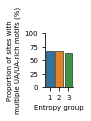

Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples-
0.0037512361173141005

Summary data-
  observed_entropy_group  multiple_UA_d2_-50_-30  count       prop
0                      1                  1540.0   2280  67.543860
1                      2                  4567.0   6840  66.769006
2                      3                  1447.0   2280  63.464912


In [29]:
fig,ax = plt.subplots(1,1, figsize = (0.5,1))

yvar = 'multiple_UA_d2_-50_-30'

plot_data          = gold_tpdata[[evar, yvar]].groupby(evar).agg('sum')
plot_data['count'] = gold_tpdata.groupby(evar).size()
plot_data['prop']  = plot_data[yvar] / plot_data['count'] * 100
plot_data.reset_index(inplace = True)

sns.barplot(data = plot_data, x = evar, y = 'prop', hue = evar, 
            palette = entropy_group_palette, dodge = False, saturation = 1,
            **barplot_format, ax = ax)

ax.set_xlabel("Entropy group")
ax.set_ylabel("Proportion of sites with\nmultiple UA/UA-rich motifs (%)")

ax.set_ylim(0,100)
ax.yaxis.set_major_locator(MultipleLocator(25))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

plt.savefig(os.path.join(OUTDIR, f'multiple_prop.{yvar}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Hypothesis test comparing two independent proportions, two-sided, assuming binomial samples-")

prop_test = test_proportions_2indep(count1 = plot_data.loc[(plot_data[evar] == ehigh), yvar].iloc[0], 
                                    count2 = plot_data.loc[(plot_data[evar] == elow ), yvar].iloc[0], 
                                    nobs1  = plot_data.loc[(plot_data[evar] == ehigh), 'count'].iloc[0],
                                    nobs2  = plot_data.loc[(plot_data[evar] == elow ), 'count'].iloc[0])
print(prop_test.pvalue)

print("\nSummary data-")
print(plot_data)


#### Distance from the last upstream UA/UA-rich motif to the maximum cleavage site

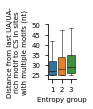


Wilcoxon rank sum test comparing entropy groups 1 and 5-
dist_last_UA_d2_-90_-30_CS 	 increased 	 7.699186724302278e-24 	 SIG

Summary data-
                         count       mean       std   min   25%   50%   75%  \
observed_entropy_group                                                        
1                       2265.0  30.564680  9.088269  25.0  25.0  27.0  32.0   
2                       6810.0  31.151101  8.541395  25.0  25.0  28.0  34.0   
3                       2272.0  32.162412  8.773561  25.0  26.0  29.0  35.0   

                         max  
observed_entropy_group        
1                       84.0  
2                       84.0  
3                       82.0  


In [30]:
cleavage.distance_boxplot(OUTDIR, 'any',
                          gold_tpdata.loc[gold_tpdata['count_UA_d2_-90_-30'] > 0], 
                          evar, 'Entropy group', [elow,ehigh], 
                          'dist_last_UA_d2_-90_-30_CS', 'Distance from last UA/UA-\nrich motif to CS in sites\nwith multiple motifs (nt)', 
                          (23,50), 5, (0.5,1))


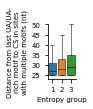


Wilcoxon rank sum test comparing entropy groups 1 and 5-
dist_last_UA_d2_-90_-30_CS 	 increased 	 1.8709562177678767e-27 	 SIG

Summary data-
                         count       mean       std   min   25%   50%   75%  \
observed_entropy_group                                                        
1                       2171.0  29.869185  7.597685  25.0  25.0  27.0  31.0   
2                       6645.0  30.815500  7.800896  25.0  25.0  28.0  33.0   
3                       2227.0  31.894477  8.322946  25.0  25.0  29.0  35.0   

                         max  
observed_entropy_group        
1                       78.0  
2                       78.0  
3                       75.0  


In [31]:
cleavage.distance_boxplot(OUTDIR, 'multiple',
                          gold_tpdata.loc[gold_tpdata['count_UA_d2_-90_-30'] > 1], 
                          evar, 'Entropy group', [elow,ehigh], 
                          'dist_last_UA_d2_-90_-30_CS', 'Distance from last UA/UA-\nrich motif to CS in sites\nwith multiple motifs (nt)', 
                          (23,50), 5, (0.5,1))
